c:\Users\Andre\anaconda3\envs\ML01\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Andre\anaconda3\envs\ML01\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Andre\anaconda3\envs\ML01\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Andre\anaconda3\envs\ML01\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Andre\anaconda3\envs\ML01\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and w

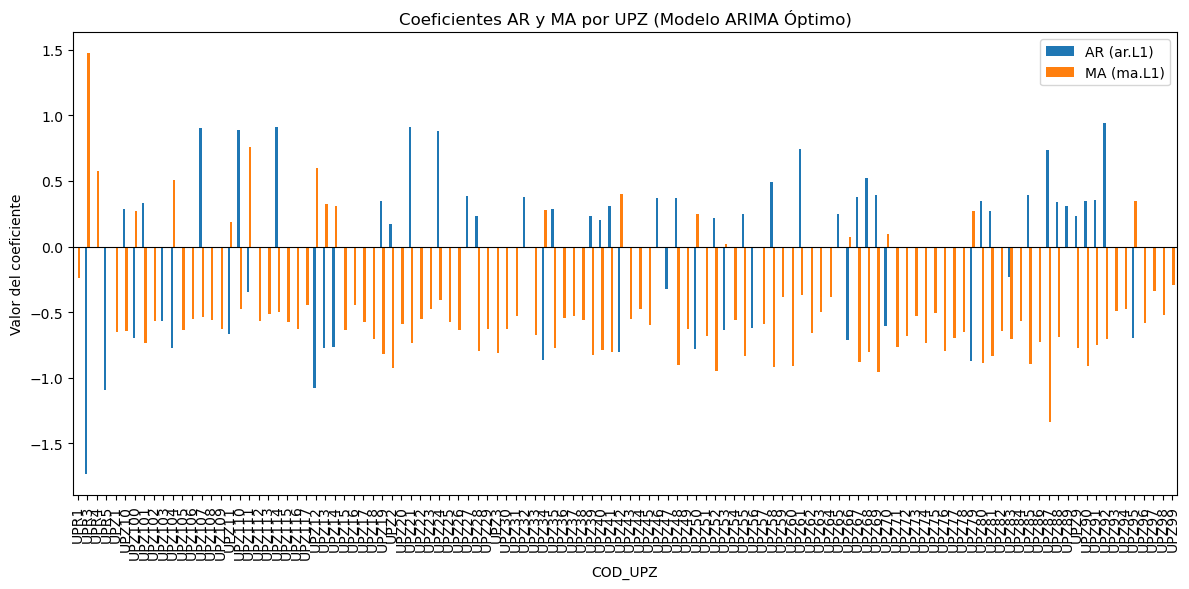

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
df = pd.read_excel('llamadasFiltrado.xlsx')

#Crear la columna de fecha
df['FECHA'] = pd.to_datetime(df['ANIO'].astype(str) + '-' + df['MES'].astype(str) + '-01')

# Diccionarios para guardar modelos, pronósticos y coeficientes
modelos = {}
pronosticos = {}
coef_ar = {}
coef_ma = {}

# Iterar por cada UPZ
for upz, grupo in df.groupby('COD_UPZ'):
    serie = grupo.groupby('FECHA')['CANT_INCIDENTES'].sum().sort_index()

    if len(serie) >= 12:
        try:
            # Encontrar la mejor configuración ARIMA
            modelo_auto = auto_arima(serie, seasonal=False, stepwise=True, suppress_warnings=True, error_action='ignore')

            # Obtener orden óptimo
            orden = modelo_auto.order

            # Ajustar el modelo ARIMA final con statsmodels (mejor para inspeccionar coeficientes)
            model = ARIMA(serie, order=orden)
            model_fit = model.fit()

            # Guardar modelo y pronóstico
            modelos[upz] = model_fit
            pronosticos[upz] = model_fit.forecast(steps=3)

            # Guardar coeficientes AR y MA
            params = model_fit.params
            coef_ar[upz] = params.get('ar.L1', 0)
            coef_ma[upz] = params.get('ma.L1', 0)

        except Exception as e:
            print(f"No se pudo ajustar ARIMA para UPZ {upz}: {e}")

# === Graficar coeficientes AR y MA ===
coef_df = pd.DataFrame({
    'AR (ar.L1)': coef_ar,
    'MA (ma.L1)': coef_ma
}).sort_index()

coef_df.plot(kind='bar', figsize=(12, 6))
plt.title("Coeficientes AR y MA por UPZ (Modelo ARIMA Óptimo)")
plt.xlabel("COD_UPZ")
plt.ylabel("Valor del coeficiente")
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


In [2]:
pronostico_list = []

for cod_upz, serie in pronosticos.items():
    temp_df = pd.DataFrame({
        'FECHA': serie.index,
        'PREDICCION': serie.values,
        'COD_UPZ': cod_upz
    })
    pronostico_list.append(temp_df)

# Unir todo en un solo DataFrame
df_pronostico = pd.concat(pronostico_list).reset_index(drop=True)


In [3]:
df['FECHA'] = pd.to_datetime(df['FECHA'])
df_pronostico['FECHA'] = pd.to_datetime(df_pronostico['FECHA'])

df_total = pd.merge(df, df_pronostico, on=['FECHA', 'COD_UPZ'], how='outer')


In [ ]:
df_pred = df_pronostico[df_pronostico['FECHA'] == '2025-06-01']  # último mes
df_pred['RIESGO'] = (df_pred['PREDICCION'] - df_pred['PREDICCION'].min()) / (
    df_pred['PREDICCION'].max() - df_pred['PREDICCION'].min())
df_pred = df_pred.rename(columns={'COD_UPZ': 'CODIGO_UPZ'})


df_pred.to_csv('df_predicciones_riesgo.csv', index=False)